# WatChMaL: MC Dropout Experiments
### Iñaki Erregue Álvarez-Buhilla

In [22]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dictances import bhattacharyya
from sklearn.metrics import *
from utils.utils import *

In [72]:
base_path = './data/'

labels = np.load(base_path+'/labels.npy')
test_idxs = np.load(base_path+'/indices.npy')
split_idxs = np.load(base_path+'/IWCD_mPMT_Short_2_class_idxs_xps.npz')

# 1 - Dropout in Training 

Normal, FC, All, for different dropout rates

In [73]:
#modes = ['nd', 'dfc', 'dcnn', 'd', 'mcd']
modes = ['101', '101mc01', '101mc02', '101mcfc02', 'uncertainties']

In [74]:
data_splitting(split_idxs)

Total num. of events:  2950284
Events for testing: 10.004
Events for validation: 2.399
Events for training: 87.596


In [75]:
results = []
for mode in modes:
    results.append(basic_metrics(base_path, labels, mode))

In [76]:
pd.set_option("display.precision", 4)
df = pd.DataFrame(results)

df['charge'] = np.where(df['model'].str.contains('Q'), 1, 0)
df['time'] = np.where(df['model'].str.contains('T'), 1, 0)
df['scaled'] = np.where(df['model'].str.contains('u'), 0, 1)
df['collapsed'] = np.where(df['model'].str.contains('s'), 1, 0)

df['total_score'] = df.acc+df.f1+df.auc-df.log_loss

df.sort_values(by='total_score', inplace=True, ascending=False)
df = df[['model','charge', 'time', 'scaled', 'collapsed', 'log_loss', 'acc', 'f1', 'auc', 'opt_threshold', 'total_score']].reset_index(drop=True)

df.head(len(modes))

,model,charge,time,scaled,collapsed,log_loss,acc,f1,auc,opt_threshold,total_score
0,uncertainties,0,0,0,1,0.5946,0.6748,0.6589,0.7433,0.4885,1.4824
1,101,0,0,1,0,0.6104,0.6646,0.6543,0.7252,0.5090,1.4337
2,101mcfc02,0,0,1,0,0.6129,0.6643,0.6568,0.7231,0.5096,1.4314
3,101mc01,0,0,1,0,0.7069,0.5177,0.5800,0.5267,0.5259,0.9176
4,101mc02,0,0,1,0,0.7588,0.4984,0.6417,0.4936,0.4363,0.8750


# 2 - MC Dropout

With previous winner, implement different dropout rates and forward passes

In [77]:
predictions = np.load('./data/uncertainties/predictions.npy')

In [78]:
predictions

array([0, 0, 0, ..., 0, 1, 1])

In [79]:
#[total_variance, entropy, mutual_info, margin_confidence, variation_ratio]
uncertainties = np.load('./data/uncertainties/uncertainties.npy')

predictions = np.expand_dims(np.load('./data/uncertainties/predictions.npy'), axis=1)
probs = np.expand_dims(np.load('./data/uncertainties/softmax.npy')[:,1], axis=1)

uncertainties = np.concatenate((uncertainties,probs,predictions,np.expand_dims(labels, axis=1)),axis=1)

In [80]:
uncertainties_df = pd.DataFrame(
    uncertainties, columns=['total_variance', 'entropy', 'mutual_info', 'margin_confidence', 'variation_ratio', 'probs', 'pred', 'gt'])

In [89]:
uncertainties_df['pred'] = uncertainties_df['pred'].astype(int)
uncertainties_df['gt'] = uncertainties_df['gt'].astype(int)

# normalize entropy
uncertainties_df['entropy'] = uncertainties_df['entropy']/np.log(2)

uncertainties_df['correct_pred'] = np.where(uncertainties_df['pred'] == uncertainties_df['gt'], 1, 0)

In [90]:
uncertainties_df

,total_variance,entropy,mutual_info,margin_confidence,variation_ratio,probs,pred,gt,correct_pred
0,0.0899,0.8819,0.0181,0.4051,0.0392,0.3005,0,0,1
1,0.1255,0.6920,0.0471,0.6329,0.0196,0.1855,0,0,1
2,0.0922,0.5684,0.0323,0.7319,0.0000,0.1340,0,0,1
3,0.0308,0.9447,0.0020,0.2752,0.0000,0.6376,1,0,0
4,0.0735,0.8946,0.0122,0.3776,0.0000,0.3112,0,0,1
...,...,...,...,...,...,...,...,...,...
295151,0.0297,0.9482,0.0018,0.2665,0.0000,0.6332,1,1,1
295152,0.0150,0.9952,0.0004,0.0817,0.0000,0.5409,1,1,1
295153,0.0407,0.9802,0.0033,0.1676,0.0196,0.4174,0,1,0
295154,0.0251,0.9548,0.0013,0.2489,0.0000,0.6245,1,1,1


In [91]:
def bhattacharyya_d(a: dict, b: dict) -> float:
    """Determine the Bhattacharyya distance beetween the given dictionaries.
    Parameters
    ----------------------------
    a: dict,
        First dictionary to consider.
    b: dict,
        Second dictionary to consider.
    Returns
    ----------------------------
    Return the Bhattacharyya distance beetween the given dictionaries.
    """
    if len(a) > len(b):
        big = a
        small = b
    else:
        big = b
        small= a
    
    total = 0
    for k in small.keys():
        total += np.sqrt(big[k] * small[k])
    
    distance = -np.log(total)
    if np.isinf(distance):
        return 0
    
    return distance

Bhattacharyya distance: 0.3615


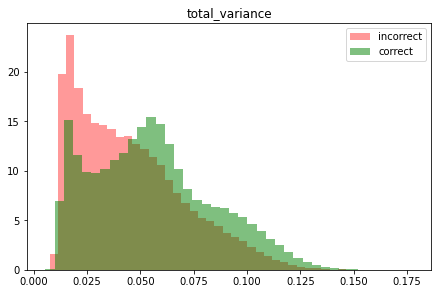

Bhattacharyya distance: 0.3485


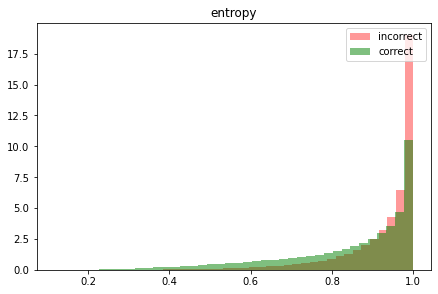

Bhattacharyya distance: 0.2700


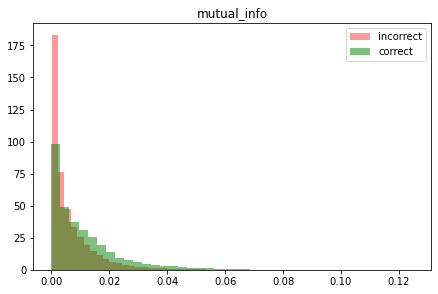

Bhattacharyya distance: 0.3617


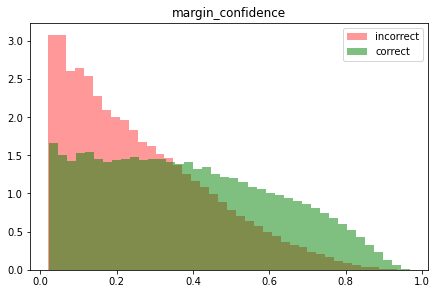

Bhattacharyya distance: 0.0135


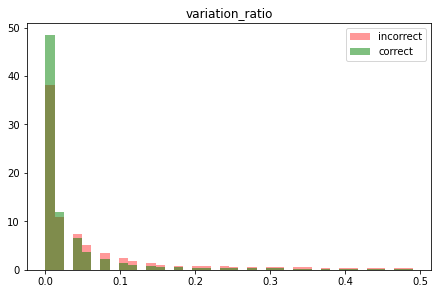

In [96]:

unc_measures = ['total_variance', 'entropy', 'mutual_info', 'margin_confidence', 'variation_ratio']
for measure in unc_measures:
    
    correct = uncertainties_df[uncertainties_df['correct_pred'] == 1][measure]
    incorrect = uncertainties_df[uncertainties_df['correct_pred'] == 0][measure]
    
    correct_pmf = correct.value_counts(normalize=True)
    incorrect_pmf = incorrect.value_counts(normalize=True)
    
    print('Bhattacharyya distance: %1.4f' % bhattacharyya_d(correct_pmf.reset_index(drop=True).to_dict(),incorrect_pmf.reset_index(drop=True).to_dict()))

    plt.hist(incorrect.values, bins=40, alpha=0.4, label='incorrect', color='r', density=1)
    plt.hist(correct.values, bins=40, alpha=0.5, label='correct', color='g', density=1)
    
    plt.legend(loc='upper right')
    plt.title(measure)
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()